# Esame di Probabilità e Statistica 

##  Carlo Bruno Torreggiani

- Analisi qualitativa della popolazione contenuta nei comuni italiani.
- andamento per ogni comune (tasso di crescita e possibili comuni morenti)
- guardare se torino si popola e poi provare a fare una mappa fikissima
- guardare la correlazione tra diversi anni del tasso di popolamento

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy.stats 
import scipy
import seaborn as sns
import matplotlib.pylab as plt


In [22]:
pip install geopandas


   ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
   - -------------------------------------- 0.8/19.2 MB 4.6 MB/s eta 0:00:05
   --- ------------------------------------ 1.8/19.2 MB 4.9 MB/s eta 0:00:04
   ----- ---------------------------------- 2.6/19.2 MB 4.8 MB/s eta 0:00:04
   ------- -------------------------------- 3.7/19.2 MB 4.7 MB/s eta 0:00:04
   --------- ------------------------------ 4.7/19.2 MB 4.7 MB/s eta 0:00:04
   ----------- ---------------------------- 5.5/19.2 MB 4.7 MB/s eta 0:00:03
   ------------- -------------------------- 6.6/19.2 MB 4.7 MB/s eta 0:00:03
   ---------------- ----------------------- 7.9/19.2 MB 4.8 MB/s eta 0:00:03
   ------------------ --------------------- 8.9/19.2 MB 4.8 MB/s eta 0:00:03
   -------------------- ------------------- 10.0/19.2 MB 4.9 MB/s eta 0:00:02
   ----------------------- ---------------- 11.3/19.2 MB 5.0 MB/s eta 0:00:02
   ------------------------- -------------- 12.3/19.2 MB 5.0 MB/s eta 0:00:02
   

In [2]:
# importo i dati ############################################################################à
inData_Residenti = pd.read_excel("/Users/carlo/Downloads/ProbStat/Esame/Residenti.xlsx", header = 1)
inData_Iscritti = pd.read_excel("/Users/carlo/Downloads/ProbStat/Esame/iscritti.xlsx", header = 1)
inData_Cancellati = pd.read_excel("/Users/carlo/Downloads/ProbStat/Esame/Cancellati.xlsx", header = 1)


# Rimuovo spazi dai nomi delle colonne per coerenza
inData_Residenti.columns = inData_Residenti.columns.str.strip()
inData_Iscritti.columns = inData_Iscritti.columns.str.strip()
inData_Cancellati.columns = inData_Cancellati.columns.str.strip()


In [3]:
# tolgo l'ultima riga perché risulta vuota
inData_Cancellati = inData_Cancellati.drop(inData_Cancellati.index[-1])
inData_Residenti = inData_Residenti.drop(inData_Residenti.index[-1])
inData_Iscritti = inData_Iscritti.drop(inData_Iscritti.index[-1])

In [4]:
#visualizzo la prima riga dei dataset
print(inData_Residenti.head(1))
print(inData_Iscritti.head(1))
print(inData_Cancellati.head(1))

  Territorio      2001      2002      2003        2004        2005  \
0     Italia  56995744  56993270  57186378  57611990.0  58044368.0   

         2006        2007        2008        2009        2010        2011  \
0  58288996.0  58510725.0  59001769.0  59420592.0  59690316.0  59948497.0   

         2012        2013        2014        2015        2016        2017  \
0  60105185.0  60277309.0  60345917.0  60295497.0  60163712.0  60066734.0   

         2018        2019  
0  59937769.0  59816673.0  
  Territorio    2001     2002     2003       2004       2005       2006  \
0     Italia  161054  1458973  1468772  1585953.0  1608581.0  1640217.0   

        2007       2008       2009       2010       2011       2012  \
0  1632812.0  1653601.0  1552324.0  1558686.0  1501523.0  1728749.0   

        2013       2014       2015       2016       2017       2018 2019  
0  1617229.0  1479721.0  1475842.0  1496027.0  1499637.0  1531483.0   ..  
  Territorio    2001     2002     2003       2004

## Analisi qualitativa della popolazione contenuta nei comuni italiani

Voglio studiare qualitativamente l'andamento della popolazione nei vari comuni italiani. Per farlo, mi interesso di come varia il numero dei comuni per numero di abitanti, osservando anche come varia nel corso degli anni. Inoltre, mi sono chiesto se la popolazione è contenuta nella maggior parte in comuni grandi o piccoli, studiando il caso della popolazione del 2019.

#### Studio del numero di comuni divisi per numero di abitanti

In [5]:
# Creo una tabella che mi mostra i numeri di comuni divisi per numero di abitanti (2001) 

# Creo intervalli (bin) da 0 a 20000 con passo 1000
bins = list(range(0, 21000, 1000))

# Etichette per gli intervalli
labels = [f'{bins[i]}-{bins[i+1]-1}' for i in range(len(bins)-1)]

# Assegno a ogni comune l'intervallo di appartenenza
intervalli = pd.cut(inData_Residenti["2001"], bins=bins, labels=labels, right=False)

# Calcolo il numero di comuni per ogni intervallo senza somma cumulativa
conteggio_per_intervallo = intervalli.value_counts().sort_index()

# Creo la tabella finale
tabella = pd.DataFrame({'Intervallo popolazione': conteggio_per_intervallo.index,
                        'Numero comuni nel 2001': conteggio_per_intervallo.values})

print(tabella)

   Intervallo popolazione  Numero comuni nel 2001
0                   0-999                    1394
1               1000-1999                    1027
2               2000-2999                     632
3               3000-3999                     428
4               4000-4999                     343
5               5000-5999                     234
6               6000-6999                     179
7               7000-7999                     163
8               8000-8999                     116
9               9000-9999                      84
10            10000-10999                      80
11            11000-11999                      67
12            12000-12999                      54
13            13000-13999                      46
14            14000-14999                      36
15            15000-15999                      37
16            16000-16999                      27
17            17000-17999                      21
18            18000-18999                      19


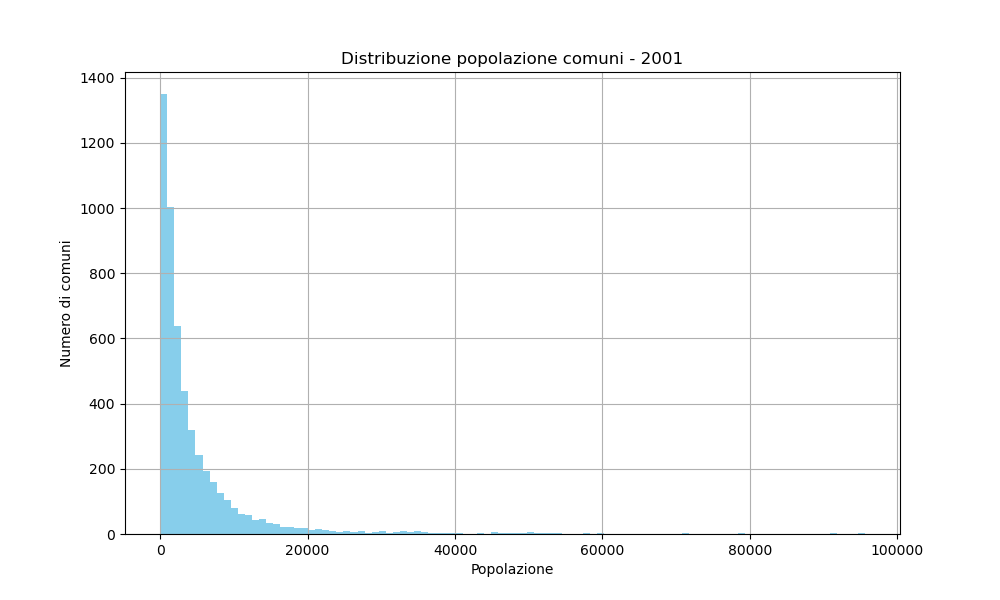

In [6]:
# Creo una gif che mi mostra gli istogrammi per ogni anno (2001-2019) 

import matplotlib.animation as animation
from IPython.display import Image

# filtro i dati così non considero le città più grandi
inData_Residenti_filtrato = inData_Residenti[inData_Residenti['2001'] < 100000]

# Ottengo la lista di anni (colonne) da analizzare
anni = [col for col in inData_Residenti_filtrato.columns if col != 'Territorio']

fig, ax = plt.subplots(figsize=(10,6))

def update(frame):
    ax.clear()
    anno = anni[frame]
    data = pd.to_numeric(inData_Residenti_filtrato[anno], errors='coerce').dropna()
    ax.hist(data, bins=100, color='skyblue')
    ax.set_title(f'Distribuzione popolazione comuni - {anno}')
    ax.set_xlabel('Popolazione')
    ax.set_ylabel('Numero di comuni')
    ax.grid(True)

ani = animation.FuncAnimation(fig, update, frames=len(anni), repeat=True)

# Salvo la GIF animata ###########################################################################################
ani.save('popolazione_comuni.gif', writer='pillow', fps=1)

plt.close(fig)


# Visualizzo la GIF #############################################################################################
Image(filename='popolazione_comuni.gif')



Si può osservare che il numero di comuni con poche persone è nettamente maggiore di molte con poche persone, con un andamento che decresce in modo monotono. Tale andamento non varia significativamente nel corso degli anni.

#### Analizzo i dati del 2019 per studiare dove è contenuta la maggior parte della popolazione

In [7]:
# Costruisco una tabella che mi mostra la percentuale di popolazione nei comuni divisi per numero di abitanti e la percentuale cumulata

inData_Residenti.columns = inData_Residenti.columns.str.strip()
residenti = inData_Residenti.loc[inData_Residenti['Territorio'] != 'Italia'].copy()
ultimo_anno = [col for col in residenti.columns if str(col).isdigit()][-1]

residenti.loc[:, ultimo_anno] = pd.to_numeric(residenti[ultimo_anno], errors='coerce')

bin_edges = list(range(0, int(residenti[ultimo_anno].max()) + 10000, 5000))
labels = [f"{bin_edges[i]}-{bin_edges[i+1]-1}" for i in range(len(bin_edges)-1)]
residenti.loc[:, 'Fascia'] = pd.cut(residenti[ultimo_anno], bins=bin_edges, labels=labels, right=False)

summary = residenti.groupby('Fascia', observed=True)[ultimo_anno].sum()
total = residenti[ultimo_anno].sum()
percent = summary / total * 100

tabella = pd.DataFrame({
    'Fascia abitanti': percent.index,
    'Percentuale popolazione': percent.values
})
filtered_tabella = tabella[tabella['Percentuale popolazione'] > 0].reset_index(drop=True)

# Calcola percentuale cumulativa
filtered_tabella['Percentuale cumulativa'] = filtered_tabella['Percentuale popolazione'].cumsum()

print(filtered_tabella)


    Fascia abitanti  Percentuale popolazione  Percentuale cumulativa
0            0-4999                16.643993               16.643993
1         5000-9999                14.926099               31.570092
2       10000-14999                 9.695086               41.265179
3       15000-19999                 6.874977               48.140156
4       20000-24999                 4.092129               52.232285
5       25000-29999                 2.983930               55.216215
6       30000-34999                 2.520939               57.737155
7       35000-39999                 2.791471               60.528626
8       40000-44999                 1.743310               62.271936
9       45000-49999                 2.562489               64.834425
10      50000-54999                 1.476690               66.311115
11      55000-59999                 0.890069               67.201184
12      60000-64999                 0.788932               67.990115
13      65000-69999               

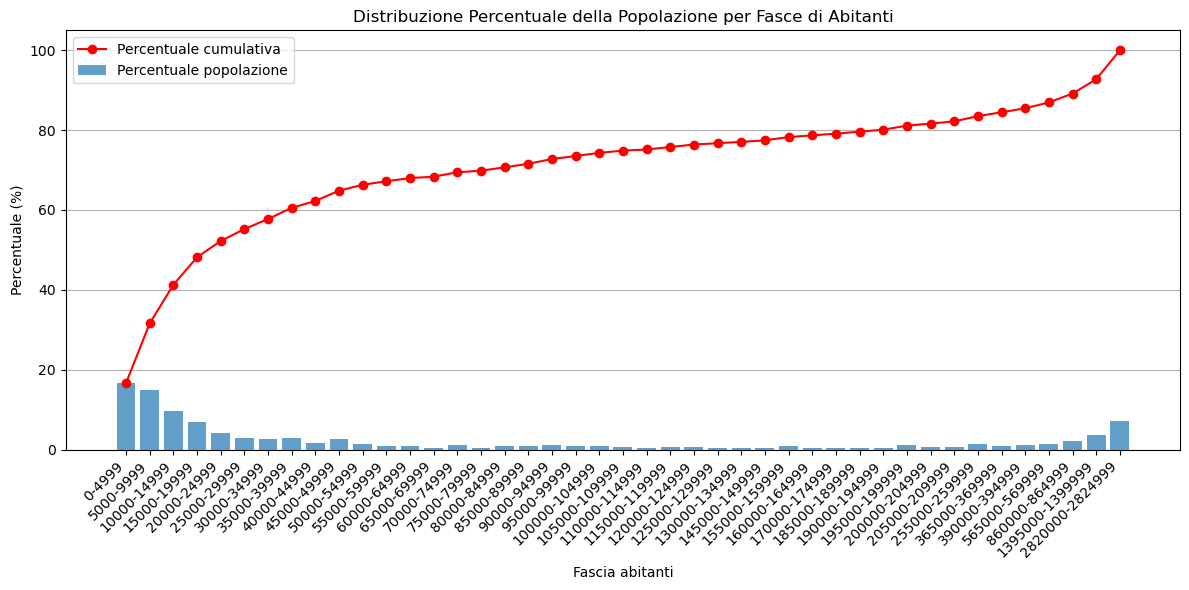

In [8]:
# Costruisco un istogramma che mi mostra la percentuale di popolazione nei comuni

plt.figure(figsize=(12, 6))

# Bar plot per percentuale popolazione
plt.bar(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale popolazione'], alpha=0.7, label='Percentuale popolazione')

# Line plot per percentuale cumulativa
plt.plot(filtered_tabella['Fascia abitanti'], filtered_tabella['Percentuale cumulativa'], color='red', marker='o', label='Percentuale cumulativa')

plt.xticks(rotation=45, ha='right')
plt.xlabel('Fascia abitanti')
plt.ylabel('Percentuale (%)')
plt.title('Distribuzione Percentuale della Popolazione per Fasce di Abitanti')
plt.legend()
plt.grid(axis='y')
plt.tight_layout()
plt.show()


Si nota che la maggior parte della popolazione (50%) è contenuta nella parte di comuni che hanno meno di 20.000 abitanti. Un contributo considerevole è anche dato dalle poche grandi città. La curva cumulativa resta pressoché piatta quando si considerano i comuni medio popolosi.

## Seconda parte

In [4]:

# Escludo la riga 'Italia'
inData_Residenti_NoTot = inData_Residenti[inData_Residenti['Territorio'] != 'Italia'].copy()
inData_Iscritti_NoTot = inData_Iscritti[inData_Iscritti['Territorio'] != 'Italia'].copy()
inData_Cancellati_NoTot = inData_Cancellati[inData_Cancellati['Territorio'] != 'Italia'].copy()

# Ottengo la lista degli anni (colonne numeriche)
anni = [col for col in inData_Residenti_NoTot.columns if str(col).isdigit()]

# Converto le colonne degli anni in numerico, evitando warning con .loc
for df in [inData_Residenti_NoTot, inData_Iscritti_NoTot, inData_Cancellati_NoTot]:
    for anno in anni:
        df.loc[:, anno] = pd.to_numeric(df[anno], errors='coerce')

# Calcolo saldo migratorio netto (iscritti - cancellati)
saldo = inData_Iscritti_NoTot.set_index('Territorio')[anni] - inData_Cancellati_NoTot.set_index('Territorio')[anni]

# Popolazione residente anno precedente (shiftata)
popolazione = inData_Residenti_NoTot.set_index('Territorio')[anni]
popolazione_shifted = popolazione.shift(axis=1)

# Sostituisco 0 con NaN nel denominatore per evitare divisione per zero
denominator = popolazione_shifted.values
denominator_safe = np.where(denominator == 0, np.nan, denominator)

# Calcolo tasso crescita netto percentuale evitando errori di divisione
with np.errstate(divide='ignore', invalid='ignore'):
    tasso_crescita_netto = saldo.values / denominator_safe
    tasso_crescita_netto = tasso_crescita_netto * 100

tasso_crescita_netto = pd.DataFrame(tasso_crescita_netto, index=saldo.index, columns=saldo.columns)

# Conto comuni in crescita e decrescita per anno
comuni_in_crescita = (tasso_crescita_netto > 0).sum(axis=0)
comuni_in_decrescita = (tasso_crescita_netto < 0).sum(axis=0)

# Tabella riassuntiva
riassunto = pd.DataFrame({
    'Anno': tasso_crescita_netto.columns,
    'Comuni in crescita': comuni_in_crescita.values,
    'Comuni in decrescita': comuni_in_decrescita.values
})
# Tolgo la prima e l'ultima riga che sono vuote
riassunto = riassunto.iloc[1:-1].copy()

print(riassunto)


    Anno  Comuni in crescita  Comuni in decrescita
1   2002                3280                  1868
2   2003                3123                  2033
3   2004                3118                  2042
4   2005                3084                  2060
5   2006                2960                  2194
6   2007                3006                  2146
7   2008                2991                  2172
8   2009                2689                  2453
9   2010                2621                  2520
10  2011                2648                  2504
11  2012                2529                  2614
12  2013                2490                  2644
13  2014                2501                  2628
14  2015                2538                  2597
15  2016                2574                  2551
16  2017                2616                  2517
17  2018                2778                  2348


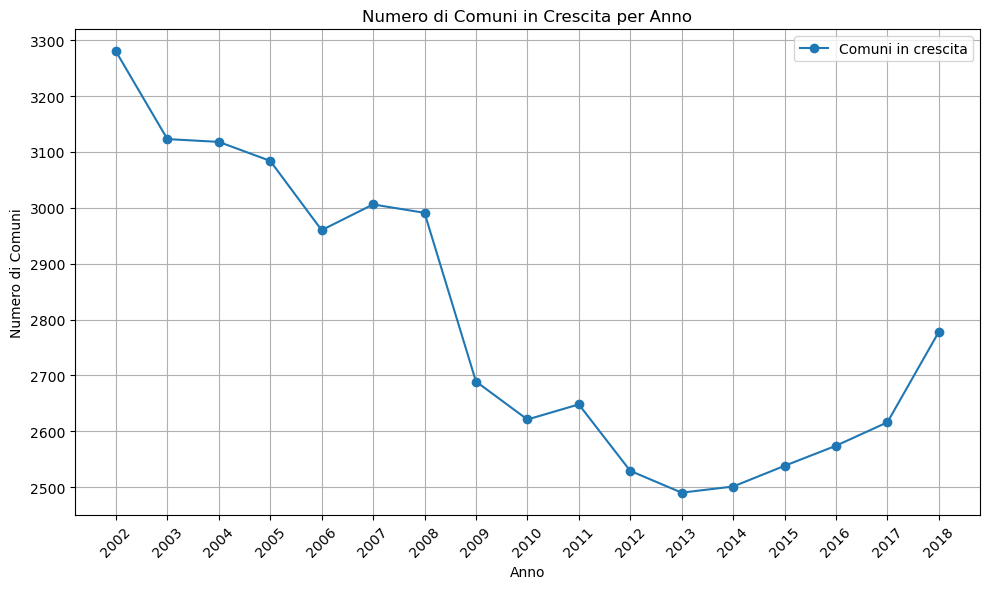

In [5]:

plt.figure(figsize=(10, 6))
plt.plot(riassunto['Anno'], riassunto['Comuni in crescita'], marker='o', label='Comuni in crescita')
#plt.plot(riassunto['Anno'], riassunto['Comuni in decrescita'], marker='o', label='Comuni in decrescita')
plt.title('Numero di Comuni in Crescita per Anno')
plt.xlabel('Anno')
plt.ylabel('Numero di Comuni')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
provincia_torino_residenti = inData_Residenti_NoTot.iloc[:312]  # prende le prime 312 righe
provincia_torino_iscritti = inData_Iscritti_NoTot.iloc[:312]  # prende le prime 312 righe
provincia_torino_cancellati = inData_Cancellati_NoTot.iloc[:312]  # prende le prime 312 righe

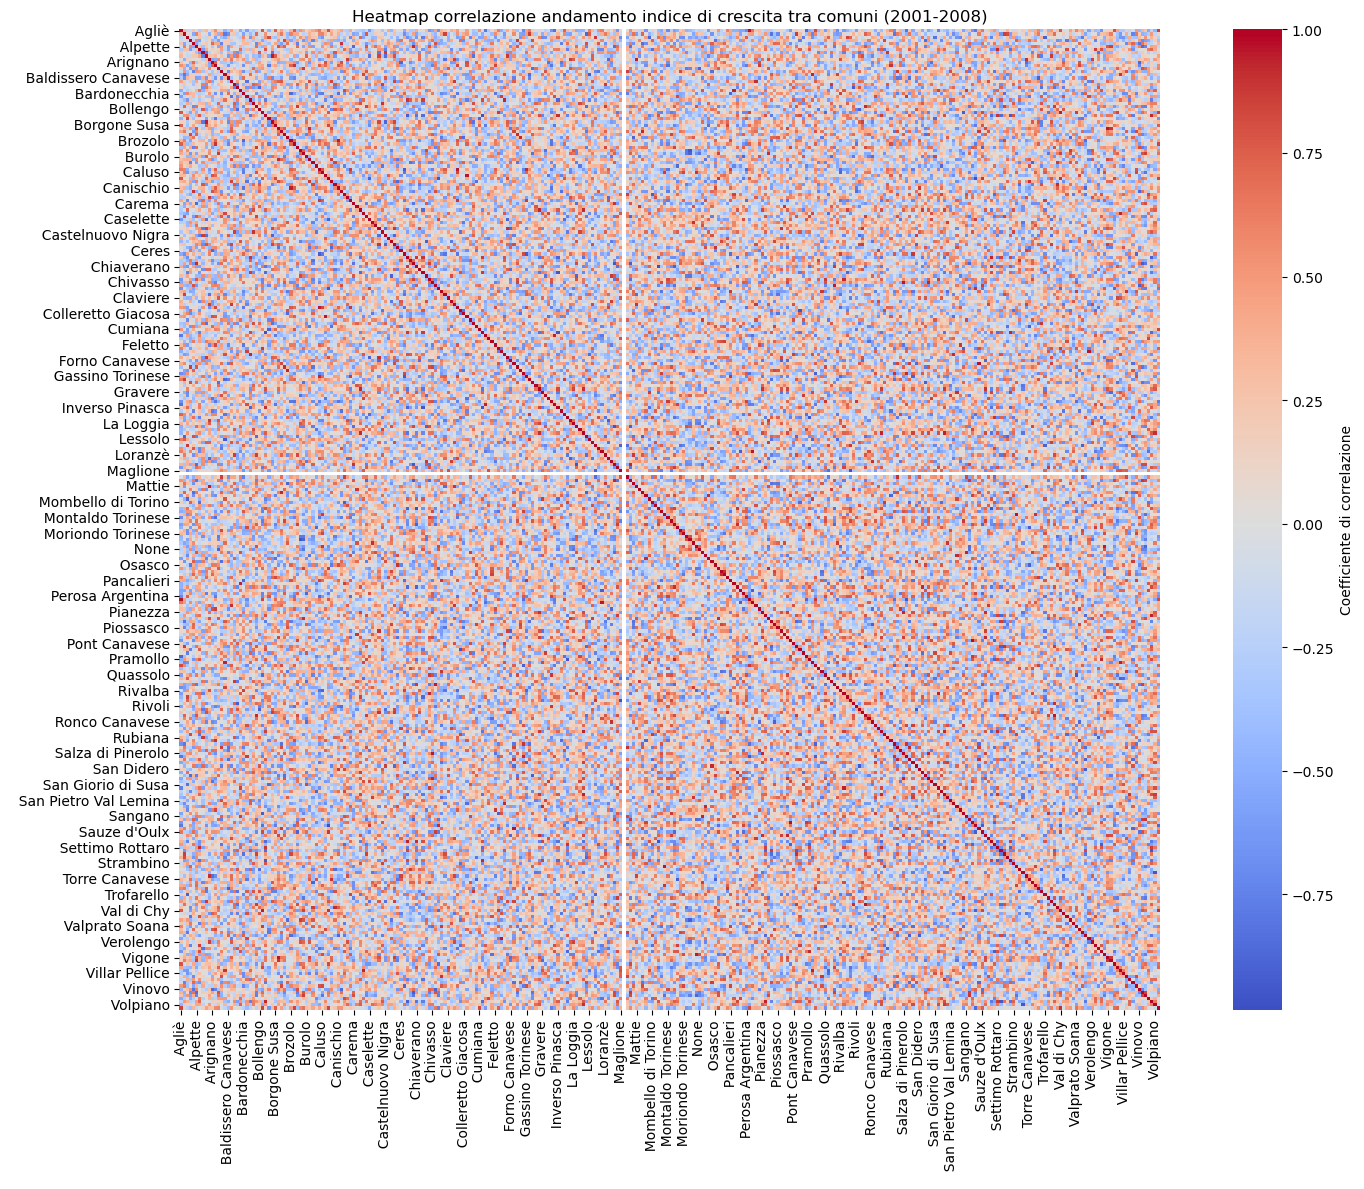

In [13]:

anni = [str(year) for year in range(2001, 2020)]

# Calcola la serie dell'indice di crescita per ogni comune per ogni anno
heatmap_data = []
comuni = provincia_torino_residenti['Territorio'].values

for idx, row in provincia_torino_residenti.iterrows():
    residenti = row[anni].astype(float).values
    iscritti = provincia_torino_iscritti.loc[idx, anni].astype(float).values
    cancellati = provincia_torino_cancellati.loc[idx, anni].astype(float).values
    variazione_netto = iscritti - cancellati
    growth_index = [(variazione_netto[i] / residenti[i]) * 100 if residenti[i] != 0 else 0 for i in range(len(anni))]
    heatmap_data.append(growth_index)

# Crea un DataFrame: ogni riga è un comune, ogni colonna è un anno
df_heatmap = pd.DataFrame(heatmap_data, index=comuni, columns=anni)

# Calcola la matrice di correlazione tra comuni per l'anno 2008
# Quindi correlazione tra comuni sui diversi anni PRIMA e INCLUSO il 2008
# Se invece vuoi solo il 2008, la correlazione tra valori singoli non ha senso.
# Ecco la correlazione tra gli interi andamenti annuali dei comuni fino al 2008:
df_subset = df_heatmap[anni[:anni.index('2008')+1]]  # Prendi solo dal 2001 al 2008
cor_matrix = df_subset.transpose().corr()  # Correlazione tra comuni (colonne: andamenti temporali)

plt.figure(figsize=(16, 12))
sns.heatmap(cor_matrix, cmap='coolwarm', center=0, square=True, cbar_kws={'label': 'Coefficiente di correlazione'})
plt.title('Heatmap correlazione andamento indice di crescita tra comuni (2001-2008)')
plt.tight_layout()
plt.show()


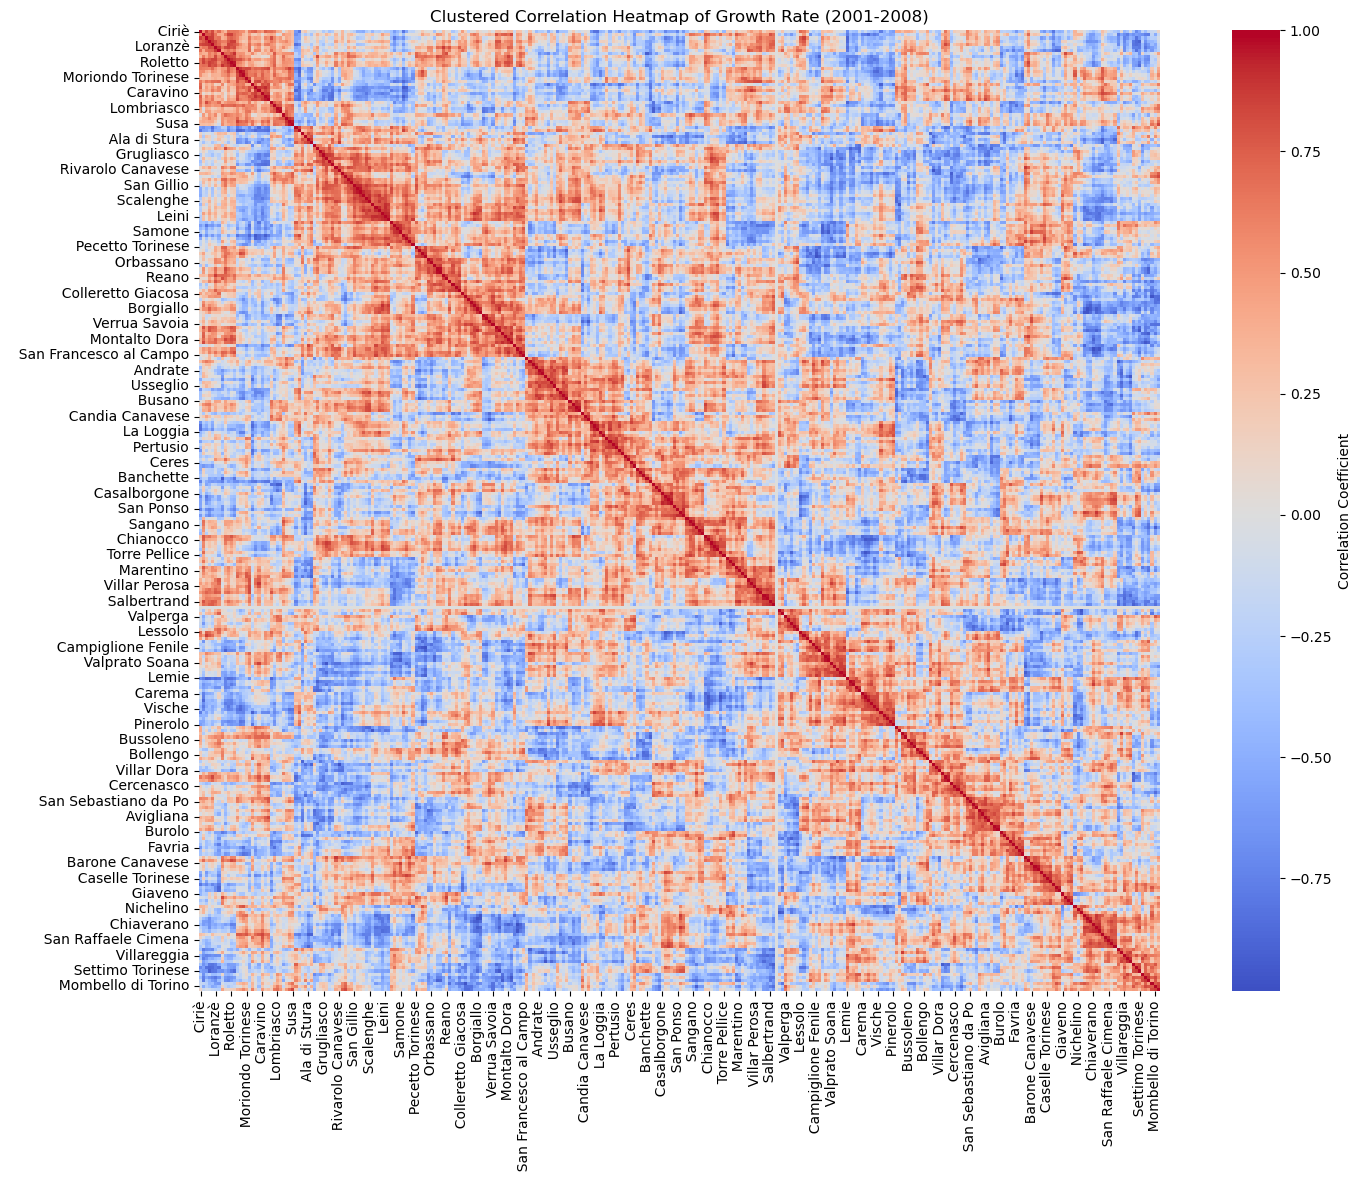

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Dati preliminari da costruire come prima
# scegliamo anni 2001-2008
anni = [str(y) for y in range(2001, 2009)]

heatmap_data = []
comuni = provincia_torino_residenti['Territorio'].values
for idx, row in provincia_torino_residenti.iterrows():
    residenti = row[anni].astype(float).values
    iscritti = provincia_torino_iscritti.loc[idx, anni].astype(float).values
    cancellati = provincia_torino_cancellati.loc[idx, anni].astype(float).values
    variazione = iscritti - cancellati
    growth_rate = [(variazione[i] / residenti[i]) if residenti[i] != 0 else 0 for i in range(len(anni))]
    growth_percent = [r * 100 for r in growth_rate]
    heatmap_data.append(growth_percent)

df_heatmap = pd.DataFrame(heatmap_data, index=comuni, columns=anni)

# Calcolo matrice correlazione (comuni x comuni)
corr_matrix = df_heatmap.T.corr()

# Replace NaN/Infs with 0
corr_matrix = corr_matrix.fillna(0).replace([np.inf, -np.inf], 0)

# Convert correlation to distance matrix (valid Euclidean distance)
distance_matrix = np.sqrt(0.5 * (1 - corr_matrix))

# Calcolo matrice distanza da correlazione
distance_matrix = np.sqrt(0.5 * (1 - corr_matrix))

# Forza diagonale a zero (assicura distanza valida)
np.fill_diagonal(distance_matrix.values, 0)

# Ora converti in formato condensato per linkage
from scipy.spatial.distance import squareform
condensed_dist = squareform(distance_matrix.values)


# Convert to condensed distance matrix format
condensed_dist = squareform(distance_matrix.values)

# Hierarchical clustering linkage
linkage = hierarchy.linkage(condensed_dist, method='average')

# Get the order of indices after clustering
idx = hierarchy.leaves_list(linkage)

# Reorder correlation matrix according to clustering
reordered_corr = corr_matrix.iloc[idx, idx]

# Plot heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(reordered_corr, cmap='coolwarm', center=0,
            square=True, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Clustered Correlation Heatmap of Growth Rate (2001-2008)')
plt.tight_layout()
plt.show()


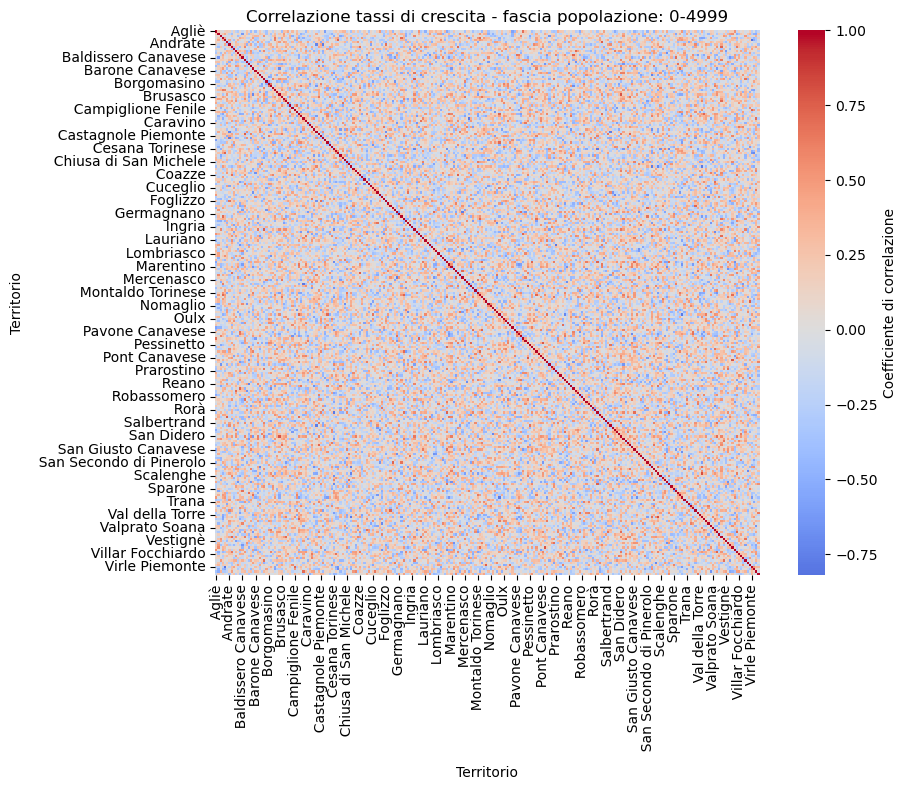

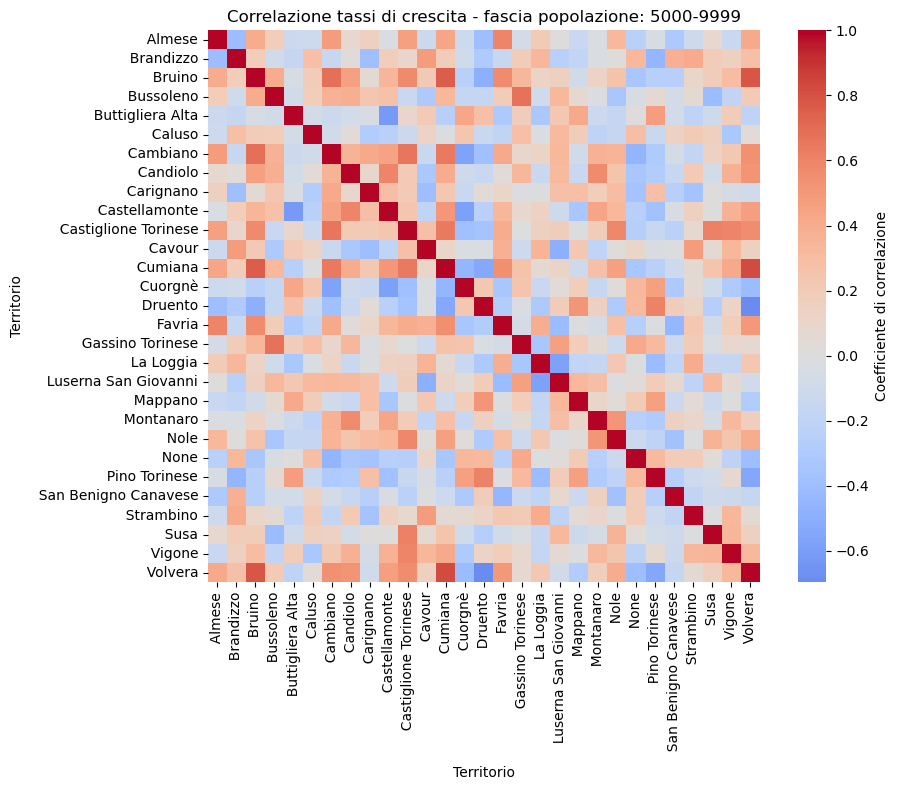

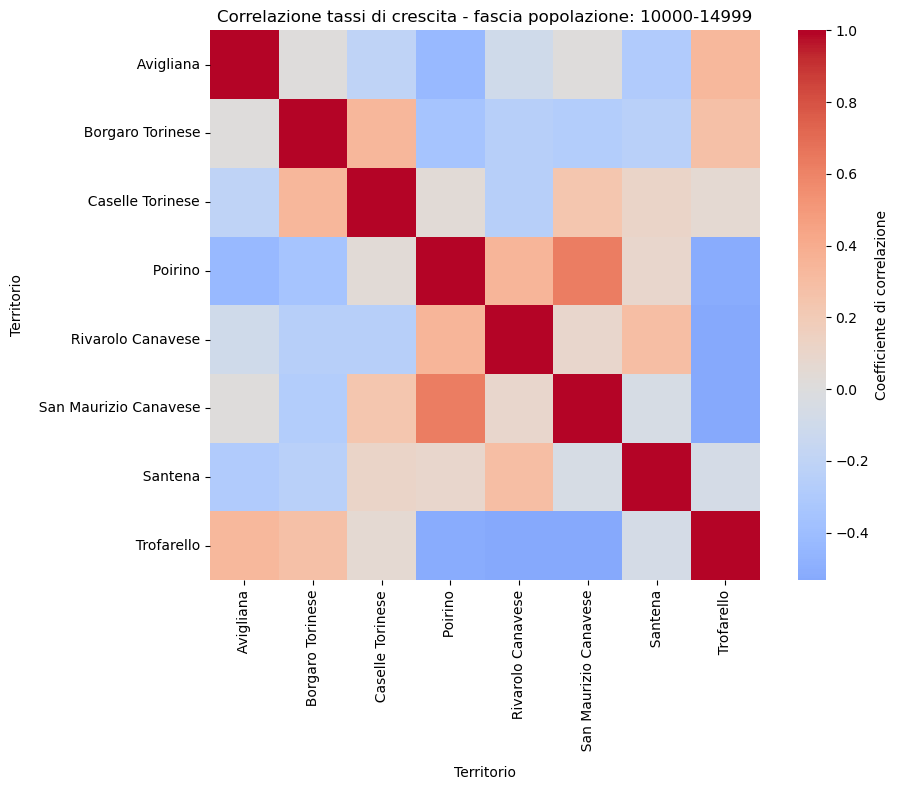

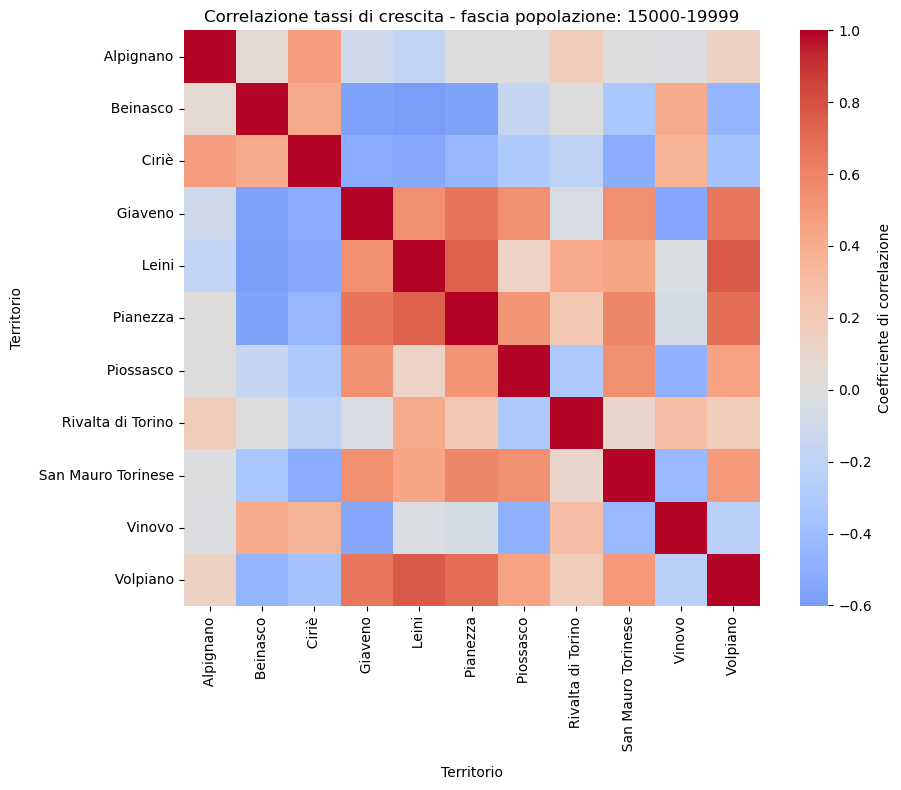

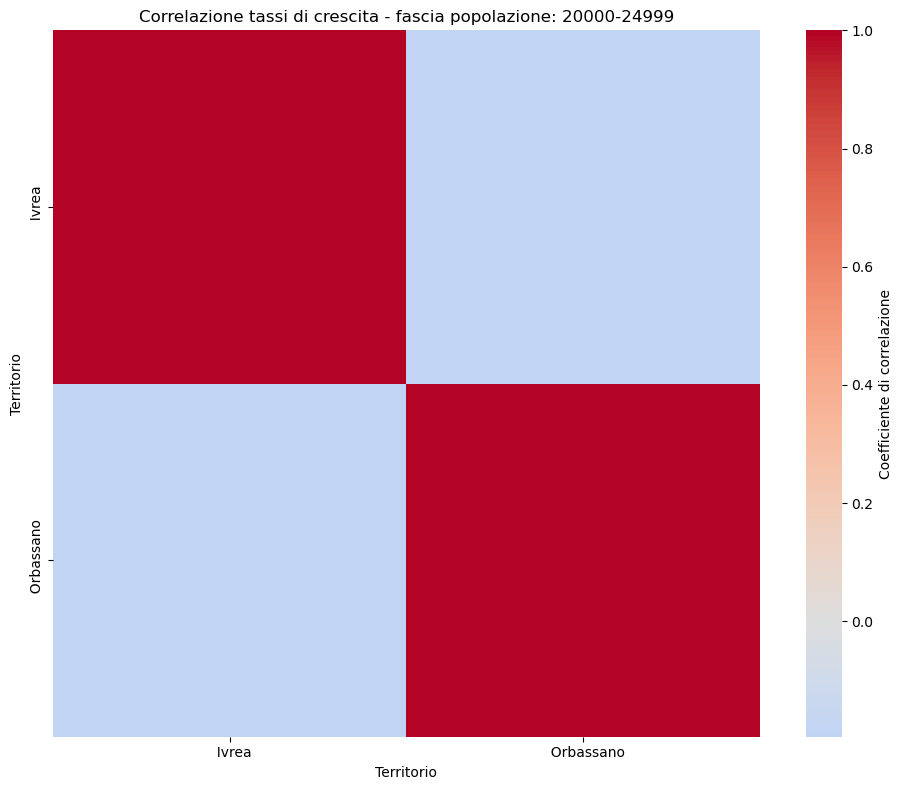

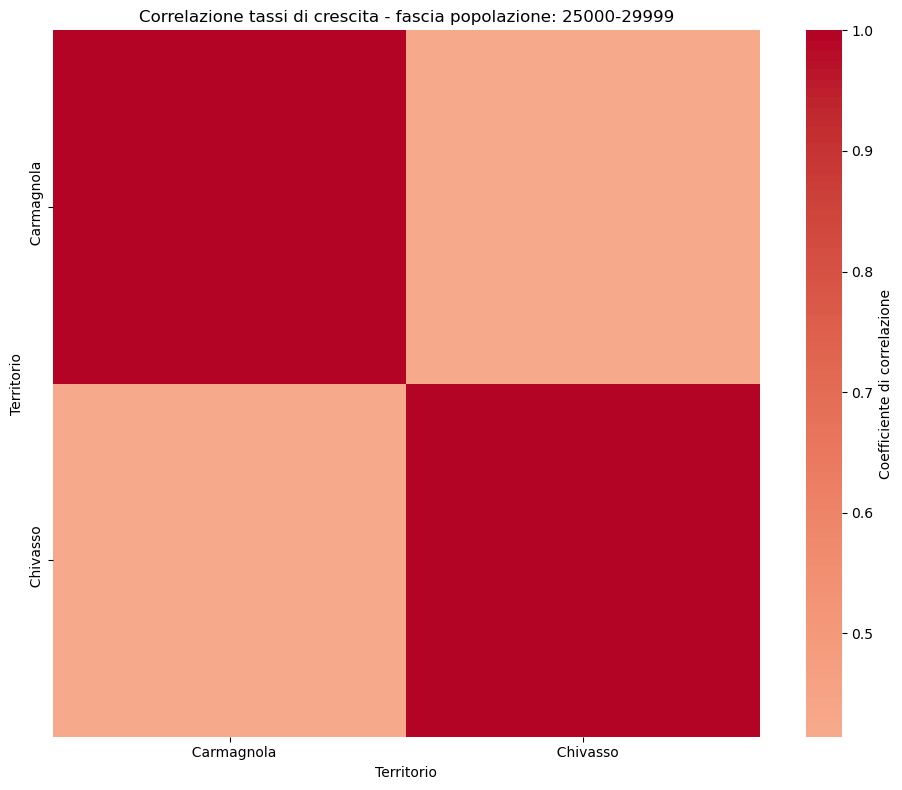

Fascia 30000-34999 ha meno di 2 comuni, heatmap non creata.


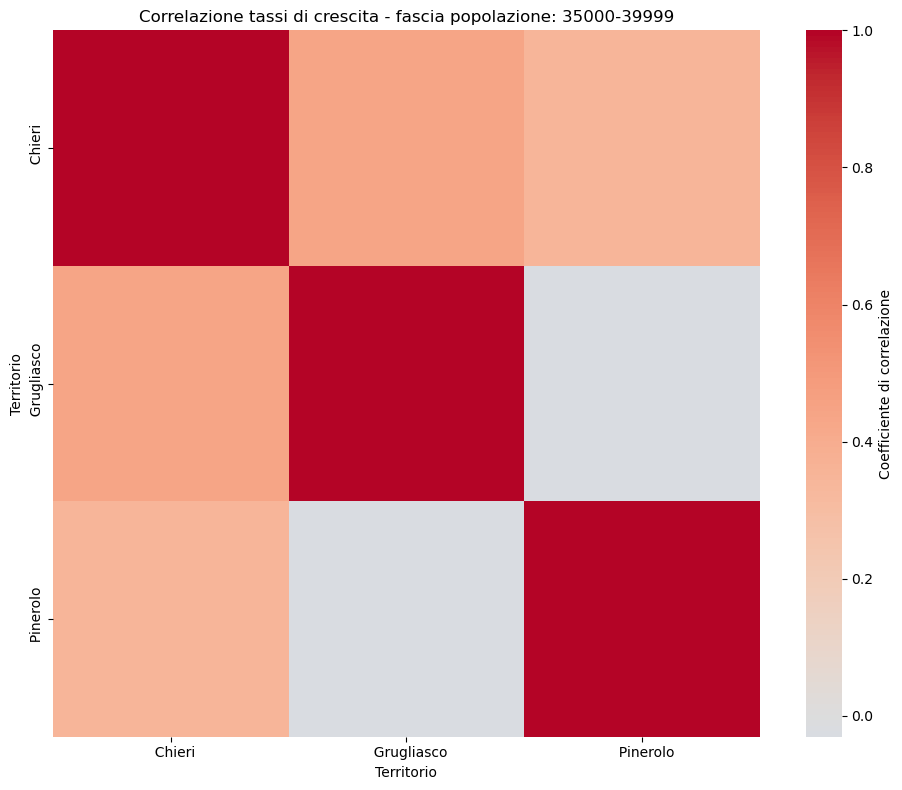

Fascia 40000-44999 ha meno di 2 comuni, heatmap non creata.


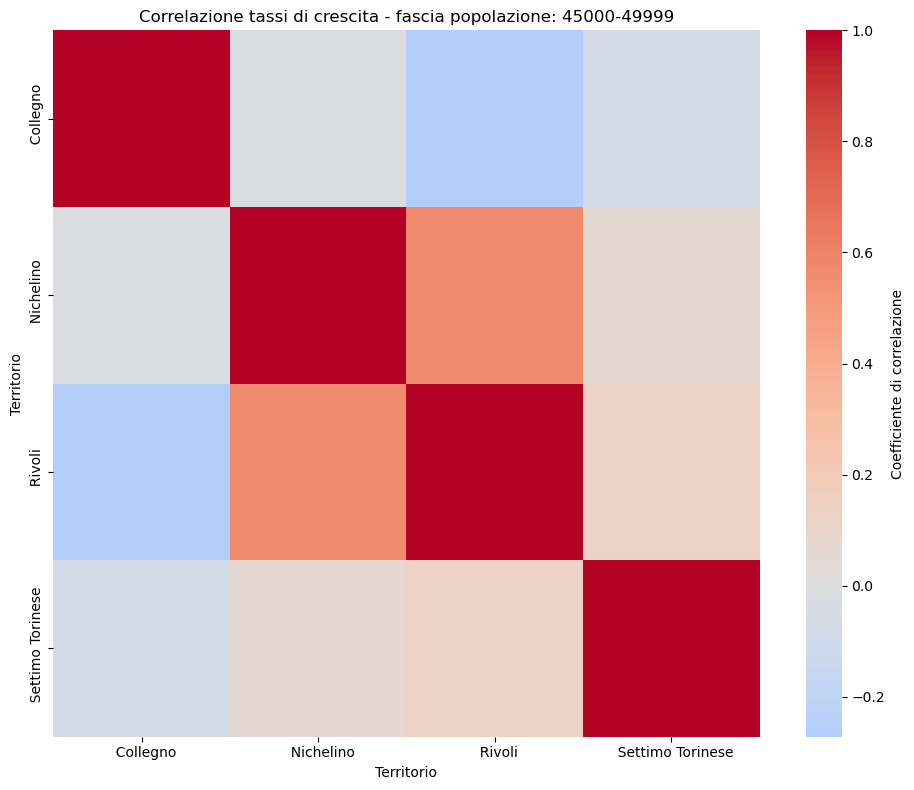

Fascia 50000-54999 ha meno di 2 comuni, heatmap non creata.
Fascia 55000-59999 ha meno di 2 comuni, heatmap non creata.
Fascia 60000-64999 ha meno di 2 comuni, heatmap non creata.
Fascia 65000-69999 ha meno di 2 comuni, heatmap non creata.
Fascia 70000-74999 ha meno di 2 comuni, heatmap non creata.
Fascia 75000-79999 ha meno di 2 comuni, heatmap non creata.
Fascia 80000-84999 ha meno di 2 comuni, heatmap non creata.
Fascia 85000-89999 ha meno di 2 comuni, heatmap non creata.
Fascia 90000-94999 ha meno di 2 comuni, heatmap non creata.
Fascia 95000-99999 ha meno di 2 comuni, heatmap non creata.
Fascia 100000-104999 ha meno di 2 comuni, heatmap non creata.
Fascia 105000-109999 ha meno di 2 comuni, heatmap non creata.
Fascia 110000-114999 ha meno di 2 comuni, heatmap non creata.
Fascia 115000-119999 ha meno di 2 comuni, heatmap non creata.
Fascia 120000-124999 ha meno di 2 comuni, heatmap non creata.
Fascia 125000-129999 ha meno di 2 comuni, heatmap non creata.
Fascia 130000-134999 ha meno

In [20]:

# Anni disponibili
anni = [str(y) for y in range(2001, 2019)]

# Calcola tasso di crescita percentuale per ogni comune e anno
growth_rates = []
for idx, row in provincia_torino_residenti.iterrows():
    residenti = row[anni].astype(float).values
    iscritti = provincia_torino_iscritti.loc[idx, anni].astype(float).values
    cancellati = provincia_torino_cancellati.loc[idx, anni].astype(float).values
    variazione = iscritti - cancellati
    tasa_crescita = [(variazione[i] / residenti[i]) * 100 if residenti[i] != 0 else 0 for i in range(len(anni))]
    growth_rates.append(tasa_crescita)

df_growth = pd.DataFrame(growth_rates, index=provincia_torino_residenti['Territorio'], columns=anni)

# Prendi la popolazione 2019 per creare le fasce
popolazione_2019 = provincia_torino_residenti['2019'].astype(float)

# Definisci le fasce da 0 a max popolazione con step 5000
step = 5000
bins = np.arange(0, popolazione_2019.max() + step, step)
labels = [f'{int(bins[i])}-{int(bins[i+1]-1)}' for i in range(len(bins)-1)]

# Assegna ogni comune alla fascia corrispondente
fasce_popolazione = pd.cut(popolazione_2019, bins=bins, labels=labels, right=False)

# Aggiungi la fascia come colonna
df_growth['fascia_pop'] = fasce_popolazione.values

# Funzione per visualizzare heatmap di correlazione per ogni fascia
def plot_heatmap_correlazione(fascia):
    subset = df_growth[df_growth['fascia_pop'] == fascia].drop(columns='fascia_pop')
    if subset.shape[0] < 2:
        print(f"Fascia {fascia} ha meno di 2 comuni, heatmap non creata.")
        return
    corr = subset.transpose().corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, cmap='coolwarm', center=0, square=True,
                cbar_kws={'label': 'Coefficiente di correlazione'})
    plt.title(f'Correlazione tassi di crescita - fascia popolazione: {fascia}')
    plt.tight_layout()
    plt.show()

# Esempio: visualizza heatmap per ogni fascia
for fascia in labels:
    plot_heatmap_correlazione(fascia)


In [7]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Carica file shapefile o GeoJSON dei comuni della provincia di Torino
# Esempio:
comuni_geo = gpd.read_file('path_to_shapefile/comuni_torino.shp')

# Assicurati che nella tabella geografica ci sia un campo comune corrispondente in nome o codice a 'Territorio'
print(comuni_geo.columns)

# Calcola il tasso di crescita per un anno (ad esempio 2019) come prima
anno = '2019'
df = provincia_torino_residenti[['Territorio', anno]].rename(columns={anno: 'residenti'})
df = df.merge(provincia_torino_iscritti[['Territorio', anno]].rename(columns={anno: 'iscritti'}), on='Territorio')
df = df.merge(provincia_torino_cancellati[['Territorio', anno]].rename(columns={anno: 'cancellati'}), on='Territorio')
df.fillna(0, inplace=True)
df['variazione_netto'] = df['iscritti'] - df['cancellati']
df['tasso_crescita'] = df.apply(lambda r: (r['variazione_netto'] / r['residenti'])*100 if r['residenti'] != 0 else 0, axis=1)

# Unisci dati demografici con dati geografici tramite colonna comune matching
# Cambia il nome della colonna comune se necessario (es. 'nome_comune' o 'COMUNE')
df_map = comuni_geo.merge(df, left_on='NOME_COMUNE', right_on='Territorio', how='left')

# Plot della mappa colorata sul tasso di crescita
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
df_map.plot(column='tasso_crescita', cmap='RdYlGn', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
ax.set_title(f'Tasso di crescita demografica per i comuni della provincia di Torino nel {anno}')
ax.axis('off')
plt.show()


DataSourceError: path_to_shapefile/comuni_torino.shp: No such file or directory